In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, balanced_accuracy_score
import joblib

# =========================
# LOAD DATA
# =========================
df = pd.read_csv("ML_Feature_Matrix.csv")

# =========================
# SELECTED FEATURES 
# =========================
FEATURES = [
    'Feature_Sync_Delta_ClassA_Frontal',
    'Feature_Theta_Global_Abs',
    'Feature_HubPLI_Beta_Delta',
    'Feature_DeltaBeta_Global',
    'Feature_Theta_Asymmetry_Idx',
]

X = df[FEATURES].values
y = df['Label_Impaired'].values

# =========================
# CONFIG
# =========================
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=4, random_state=4224)  # Repeated 5x5 CV

scoring_metrics = {
    'AUC': 'roc_auc',
    'Accuracy': 'accuracy',
    'F1': make_scorer(f1_score),
    'Precision': make_scorer(precision_score),
    'Recall': make_scorer(recall_score),
    'BalancedAcc': make_scorer(balanced_accuracy_score)
}

# =========================
# FINAL MODEL PIPELINE
# =========================
final_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # optional for RF
    ('rf', RandomForestClassifier(
        n_estimators=500,
        random_state=4224,
        max_depth=10
    ))
])

# =========================
# CROSS-VALIDATED EVALUATION
# =========================
cv_results = cross_validate(final_pipeline, X, y, cv=cv, scoring=scoring_metrics, return_train_score=False)

print("\n--- Final 5-Feature Model Repeated CV Performance ---")
for metric_name, scores in cv_results.items():
    if metric_name.startswith('test_'):
        print(f"{metric_name[5:]}: {np.mean(scores):.3f} ± {np.std(scores):.3f}")

# =========================
# TRAIN FINAL MODEL ON FULL DATA
# =========================
final_pipeline.fit(X, y)

# =========================
# FEATURE IMPORTANCE
# =========================
rf_model = final_pipeline.named_steps['rf']
importances = pd.Series(rf_model.feature_importances_, index=FEATURES).sort_values(ascending=False)

print("\n--- Feature Importances ---")
print(importances)

# =========================
# SAVE MODEL
# =========================
joblib.dump(final_pipeline, "PD_MoCA_RF_5Feature_Final.pkl")
print("\nFinal model saved as PD_MoCA_RF_5Feature_Final.pkl")

# Individual fold scores
print(f"Individual Fold AUCs: {cv_results['test_AUC']}")
print(f"Individual Fold Accs: {cv_results['test_Accuracy']}")



--- Final 5-Feature Model Repeated CV Performance ---
AUC: 0.804 ± 0.096
Accuracy: 0.725 ± 0.060
F1: 0.728 ± 0.078
Precision: 0.761 ± 0.076
Recall: 0.720 ± 0.145
BalancedAcc: 0.724 ± 0.058

--- Feature Importances ---
Feature_Theta_Global_Abs             0.252501
Feature_Sync_Delta_ClassA_Frontal    0.210059
Feature_Theta_Asymmetry_Idx          0.201642
Feature_HubPLI_Beta_Delta            0.179760
Feature_DeltaBeta_Global             0.156038
dtype: float64

Final model saved as PD_MoCA_RF_5Feature_Final.pkl
Individual Fold AUCs: [0.88888889 0.67676768 0.91919192 0.81       0.77       0.90909091
 0.83838384 0.73737374 0.82       0.82       0.58585859 0.8989899
 0.65656566 0.83       0.85       0.8989899  0.95959596 0.74747475
 0.7        0.755     ]
Individual Fold Accs: [0.8  0.7  0.8  0.7  0.7  0.7  0.75 0.65 0.75 0.7  0.65 0.75 0.65 0.75
 0.8  0.8  0.85 0.7  0.65 0.65]


Text(0.5, 1.0, 'Cross-Validated Confusion Matrix (%)')

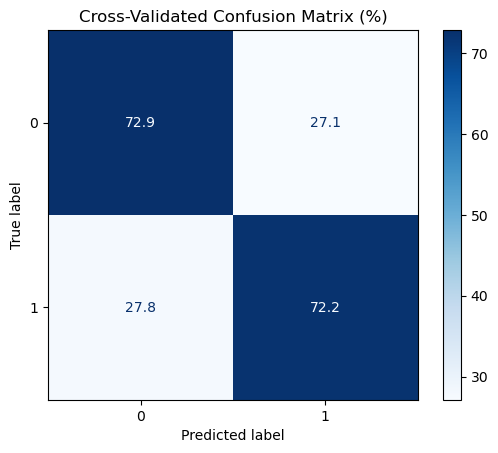

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# =========================
# CROSS-VALIDATED PREDICTIONS
# =========================
y_true_all = []
y_pred_all = []

for train_idx, test_idx in cv.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Fit pipeline on training fold
    final_pipeline.fit(X_train, y_train)

    # Predict on test fold
    y_pred = final_pipeline.predict(X_test)

    # Store for combined confusion matrix
    y_true_all.extend(y_test)
    y_pred_all.extend(y_pred)

# =========================
# CROSS-VALIDATED CONFUSION MATRIX (Percent)
# =========================
cm_cv = confusion_matrix(y_true_all, y_pred_all, normalize='true') * 100  # convert to percentages
disp_cv = ConfusionMatrixDisplay(confusion_matrix=cm_cv, display_labels=final_pipeline.named_steps['rf'].classes_)
disp_cv.plot(cmap='Blues', values_format=".1f")  # one decimal place
disp_cv.ax_.set_title("Cross-Validated Confusion Matrix (%)")
